# 2021-09-01 Further tweaks to acceleration-aware estimation

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/c2773b8e8a6fbe67f7d128db7dc658b8958eab75
    
(Rerunning the code below for other commits is not guaranteed to give the same results)

I realised that the problem mentioned at the end of the 2021-08-31 diary entry was that behaviours for the other agent are defined based on the *current* behaviour of the ego agent (time $t$), not predicted time ($t + T_\mathrm{P}$), which meant that the pedestrian acceleration at the start of that simulation was interpreted as an acceleration that would be maintained indefinitely into the future, prompting the high needed vehicle acceleration to pass first.

After further thinking I have come to the conclusion that it makes sense to define the behaviours based on current ego state, without acceleration, but still consider acceleration in the future states used for value estimation. Adding text to the SCPaper README to document this, and have now modified some functions in `sc_scenario_helper` to calculate entry/exit times into the conflict space both with and without consider acceleration, and others to allow the caller to specify which type of prediction to use.

# Init

In [2]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:87: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


## Unit tests, reproducing earlier results

Just the base model, no interaction

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


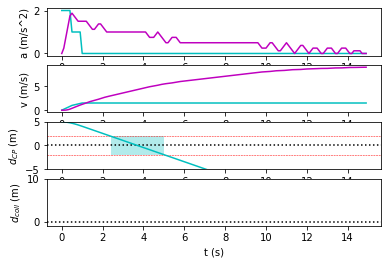

In [3]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, surplus_action_vals = False)

Baseline kinematics, base model.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


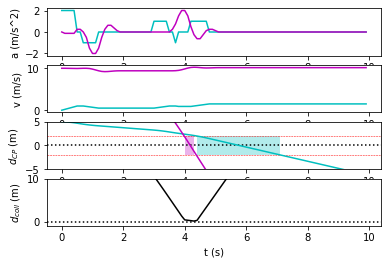

In [4]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False,
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs)

run_baseline_kinematics(dist0s = (40,))

## Turning on `oBEo`

This is the simulation that became quite strange in the 2021-08-31 diary entry. It now behaves sort of ok, but I was a bit surprised that the vehicle steamed ahead at around 0.5 s, while at the same time being fully convinced that the pedestrian would pass first. Then I realised that with these new "acceleration-aware" value estimates, if two agents are on a constant collision course, then both agents will still tend to be convinced that there is no collision problem to deal with, because their only available beliefs are that the other agent will either pass in front of or behind them, and the predictions in both cases look really nice.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


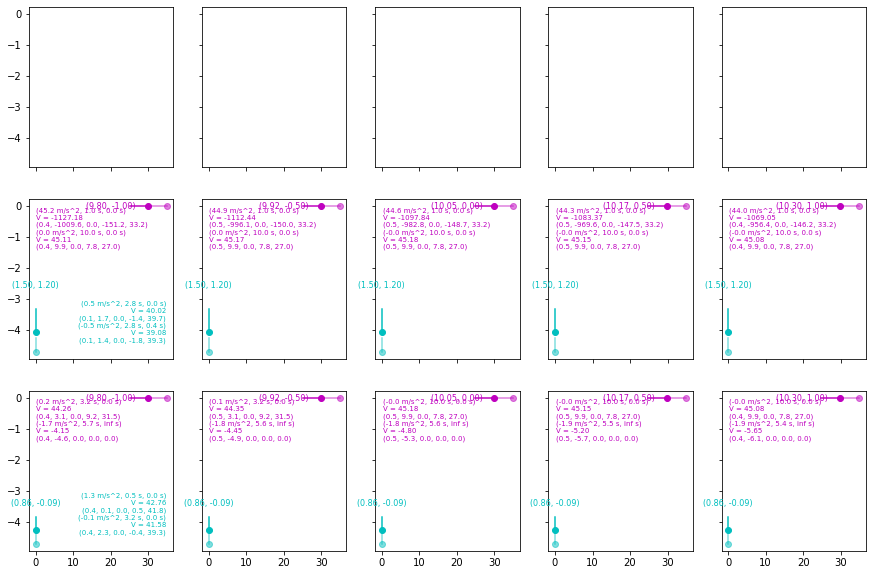

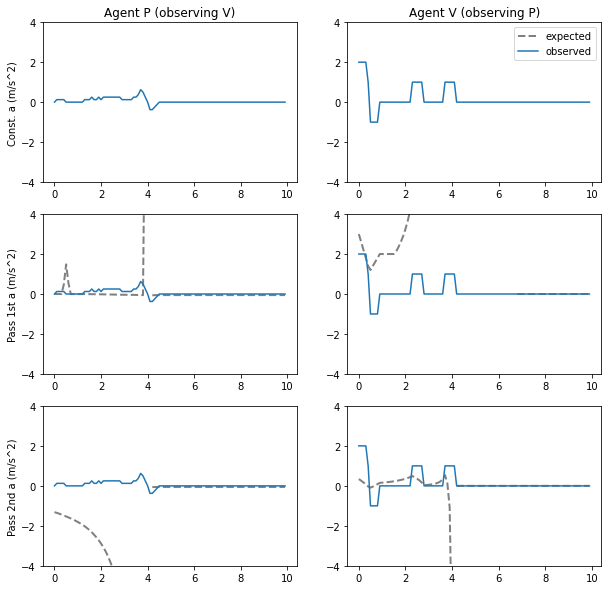

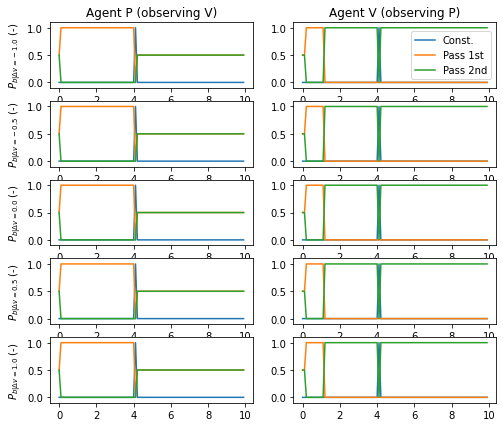

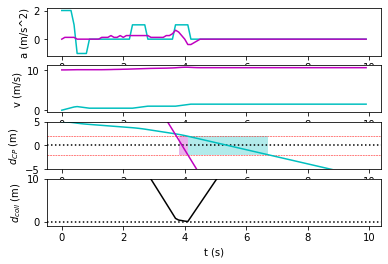

In [7]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True, plot_beh_accs = True, veh_snaps = (0.5,))

This means that all of a sudden we start getting problems with collisions, like for example below we can see that this happens to be the case when I enable `oBEv` instead of `oBEo`:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


Initial car distance 40 m:


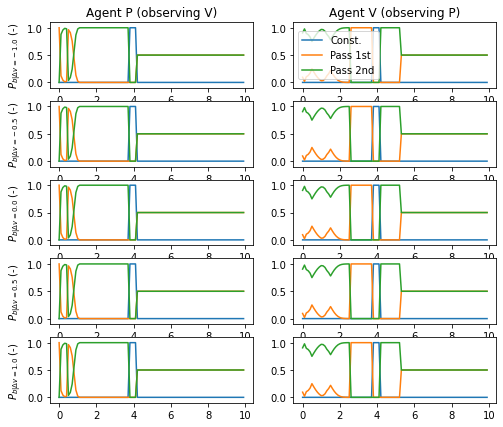

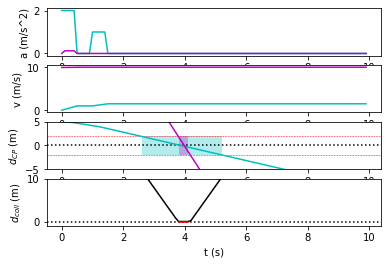

In [8]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEv = True)
run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)

So basically if we are to include acceleration-aware value estimates, then it seems like one would need to include at least also constant acceleration as a potential behaviour of the other agent. I have played around a little with that, and it does become very messy, and seems to lose a lot of the nice behaviours I have been seeing with the model before I started trying out this acceleration-aware stuff. So my inclination at this point is to back out of this, and return to the non-acceleration-aware formulation, and deal with the `oBEo` limitations that one was throwing up (see 2021-08-27) in some other way, later on.

## Simplified case like in the Keio study

Anyway returning to this case from 2021-08-27, which was what prompted me to consider this "acceleration-aware" value estimation to begin with, just to see that it has the intended effect here. With the acceleration-aware value estimation, when the pedestrian feels convinced that the car is stopping, the pedestrian begins crossing, as one would expect. But as mentioned above, this change in the model seems to create more problems than it solves...

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


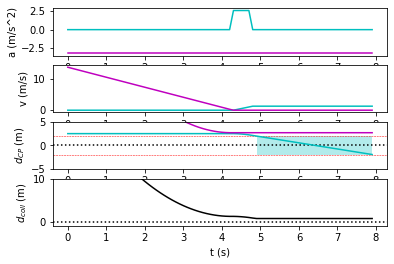

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:200: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')


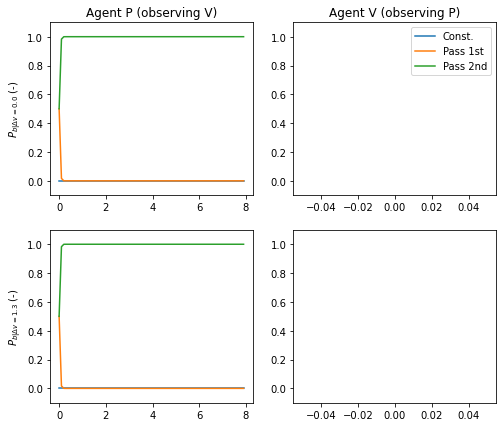

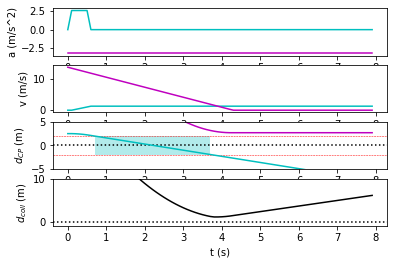

Agent P entered conflict area at t = 0.70 s
Agent V did not enter the conflict area.


In [9]:
import math

def run_keio_scenario(time_step = 0.1, T_P = 0.5, sigma_O = 0.01, oBEo = False, ped_snapshot_times = None):
    INITIAL_POSITIONS = np.array([[0,-2.5], [13.9*2.29, 0]])
    GOALS = np.array([[0, 5], [-50, 0]])
    SPEEDS = np.array((0, 13.9))
    stop_dist = INITIAL_POSITIONS[1][0] - sc_scenario.SHARED_PARAMS.d_C
    CONST_ACCS = (None, -SPEEDS[1] ** 2 / (2 * stop_dist))

    # only a single move-forward action
    sc_scenario.DEFAULT_PARAMS.ctrl_deltas = np.array([0, 1.3])
    sc_scenario.i_NO_ACTION = np.argwhere(sc_scenario.DEFAULT_PARAMS.ctrl_deltas == 0)[0][0]
    sc_scenario.N_ACTIONS = len(sc_scenario.DEFAULT_PARAMS.ctrl_deltas)

    # set parameters and optional assumptions
    AFF_VAL_FCN = True
    (params, params_k) = get_default_params(oVA = AFF_VAL_FCN)
    params.T_P = T_P
    params.T_O = math.inf
    params.sigma_O = sigma_O
    optional_assumptions = get_assumptions_dict(default_value = False, oVA = AFF_VAL_FCN,
                                               oBEo = oBEo)  

    # run simulation
    SNAPSHOT_TIMES = (ped_snapshot_times, None)
    sc_simulation = SCSimulation(
            CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
            end_time = 8, optional_assumptions = optional_assumptions,
            const_accs = CONST_ACCS, agent_names = NAMES, 
            params = params, snapshot_times = SNAPSHOT_TIMES, time_step=time_step)
    sc_simulation.run()

    # plot and give some results feedback
    sc_simulation.do_plots(kinem_states=True, beh_probs=oBEo)
    for agent in sc_simulation.agents:
        ca_entered = np.nonzero(np.linalg.norm(agent.trajectory.pos, axis=0)
                                <= sc_scenario.SHARED_PARAMS.d_C)[0]
        if len(ca_entered) == 0:
            print('Agent %s did not enter the conflict area.' % agent.name)
        else:
            print('Agent %s entered conflict area at t = %.2f s' 
                  % (agent.name, sc_simulation.time_stamps[ca_entered[0]]))
            
run_keio_scenario(oBEo=False)
run_keio_scenario(oBEo=True)